# A visualization trick obvious in hindsight

Data visualization is a key part of every data science and machine learning project. It can be difficult given that we usually have more points to draw than space on screen. Most of us realize pretty quickly that we can summarize data for certain visualizations, the most common being the histogram. What took me an embarrassingly long time to realize is that scatterplots can be easily handled by its generalization: the $nd$-histogram.

Note: The [Datashader project](https://datashader.org/user_guide/Plotting_Pitfalls.html) has a good discussion of issues that worsen as data size increases.

In [1]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

As an example, I will plot pickups from the NYC taxi dataset. The data are large enough to require care in my little Docker container.

In [2]:
df = dd.read_csv("data/nyc_taxi.csv")
n = len(df)
(n, df.shape[1])

(10679307, 19)

The process is generalizable from 1 to $n$ columns. In this case, I want to the two-dimensional scatterplot of $x$ and $y$ (longitude and latitude) pickup points. 

Traditional $nd$-histograms require the ranges of inputs to properly quantized data. I do not know these _a priori_, so I must calculate them from the data.

In [3]:
cols = ["pickup_x", "pickup_y"]

ranges = (
    df[cols]
    .groupby(lambda _: 0)
    .agg(["min", "max"])
    .compute()
    .squeeze()
    .unstack(level=1)
)

The quantization process is the same as you have likely worked through for a $1d$-histogram: given a bin count, calculate the bin for a value and replace it the bin's value in the original scale.

The key to using an $nd$-histogram to replace a scatter plot is to use an appropriately large number of bins.

In [23]:
bins = 600
widths = (ranges["max"] - ranges["min"]) / bins

quantized = (
    np.minimum((df[cols] - ranges["min"]) // widths, bins - 1)
    + 0.5
) * widths

points = (
    quantized.groupby(cols)
    .size()
    .to_frame("weight")
    .reset_index()
    .compute()
)

len(points)

100539

[`matplotlib`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist2d.html) and [`plotly`](https://plotly.com/python-api-reference/generated/plotly.graph_objects.histogram2d.html)$\dagger$ both natively support two-dimensional histograms. It's trivial to supply our points to one of them.

$\dagger$ Caution! Make sure to read the `plotly` options and disable certain features when using very high bin counts.

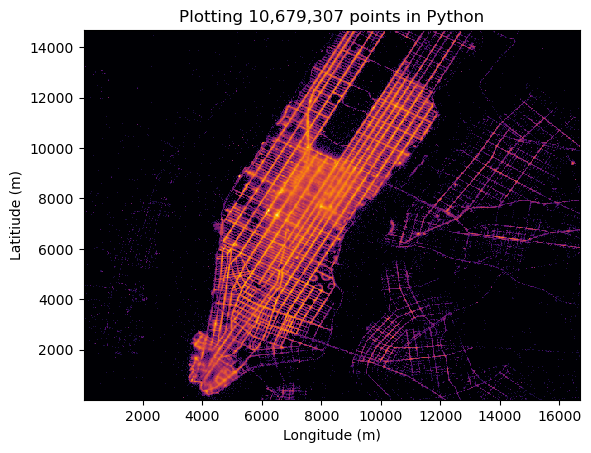

In [24]:
fig, ax = plt.subplots()
ax.hist2d(
    points["pickup_x"],
    points["pickup_y"],
    bins,
    weights=points["weight"],
    cmap="inferno",
    norm="symlog",
)
ax.set(
    title=f"Plotting {n:,} points in Python",
    xlabel="Longitude (m)",
    ylabel="Latitiude (m)",
);

## A note on Datashader

[Datashader](https://datashader.org/) is a fantastic project that supports other visualizations using the same principle of pixel-level aggregation of data prior to visualization. It integrates well with PyData tools (`pandas`, `dask`, etc.) and other tools within the larger [HoloViz](https://holoviz.org/) project. If that works for you, then you should absolutely take advantage.

However, Datashader isn't always an option. For example, my workflows primarily involve non-Python tools like Spark and Snowflake. The technique described above allows me to efficiently and natively perform aggregations and visualize the results.